# Problem statement

The sinking of the Titanic on April 15th, 1912 is one of the most tragic tragedies in history. The Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers. The numbers of survivors were low due to the lack of lifeboats for all passengers and crew. Some passengers were more likely to survive than others, such as women, children, and upper-class. This case study analyzes what sorts of people were likely to survive this tragedy. The dataset includes the following: 

- Pclass:	Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)
- Sex:    Sex	
- Age:    Age in years	
- Sibsp:	# of siblings / spouses aboard the Titanic	
- Parch:	# of parents / children aboard the Titanic	
- Ticket:	Ticket number	
- Fare:	Passenger fare	
- Cabin:	Cabin number	
- Embarked:	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


- Target class: Survived: Survival	(0 = No, 1 = Yes)


# Step 1: Data reading and insight

In [1]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('whitegrid')
plt.style.use('seaborn-deep')

import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import random


seed = 12
np.random.seed(seed)

from datetime import date

In [4]:
# read the data using pandas dataframe
titanic = pd.read_csv('../input/titanic/train.csv')
titanic_test = pd.read_csv('../input/titanic/test.csv')

titanic.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# important funtions
def datasetShape(df):
    rows, cols = df.shape
    print("The dataframe has",rows,"rows and",cols,"columns.")
    
# select numerical and categorical features
def divideFeatures(df):
    numerical_features = df.select_dtypes(include=[np.number]).drop('Survived', axis=1)
    categorical_features = df.select_dtypes(include=[np.object])
    return numerical_features, categorical_features


In [6]:
# check dataset shape
datasetShape(titanic)

# check for duplicates
if(len(titanic) == len(titanic['PassengerId'].unique())):
    print("No duplicates found!!")
else:
    print("Duplicates occuring")

The dataframe has 891 rows and 12 columns.
No duplicates found!!


In [7]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Step 2: EDA

In [9]:
# check null values

pd.DataFrame(titanic.isnull().sum(), columns=["Null Count"]).style.background_gradient(cmap='Blues')


,Null Count
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [10]:
numerical_features, categorical_features = divideFeatures(titanic)

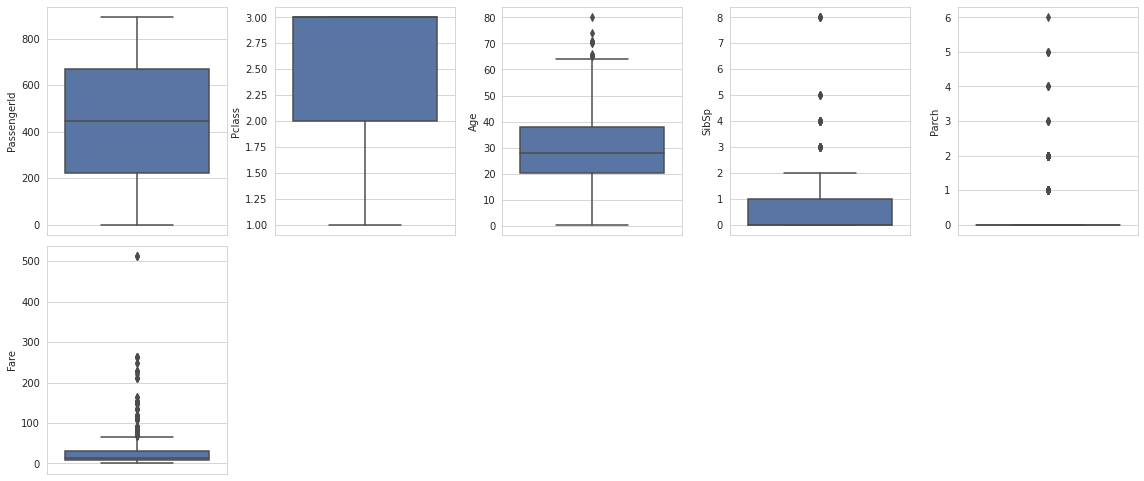

In [11]:
# boxplots of numerical features for outlier detection

fig = plt.figure(figsize=(16,30))
for i in range(len(numerical_features.columns)):
    fig.add_subplot(9, 5, i+1)
    sns.boxplot(y=numerical_features.iloc[:,i])
plt.tight_layout()
plt.show()

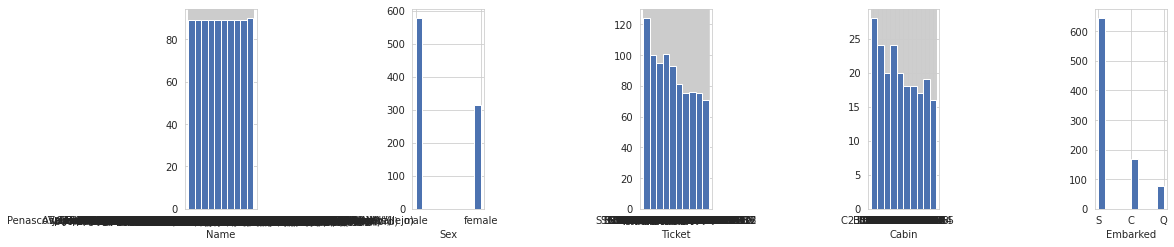

In [12]:
# distplots for categorical data

fig = plt.figure(figsize=(16,30))
for i in range(len(categorical_features.columns)):
    fig.add_subplot(9, 5, i+1)
    categorical_features.iloc[:,i].hist()
    plt.xlabel(categorical_features.columns[i])
plt.tight_layout()
plt.show()

plot the % of the target variable

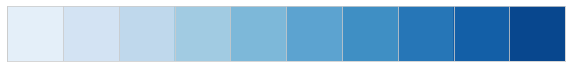

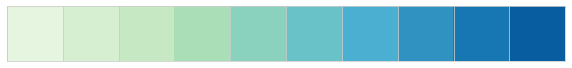

In [13]:
sns.color_palette("Blues", as_cmap=True)
GnBu_palette = sns.color_palette("GnBu",10)
Blues_palette = sns.color_palette("Blues",10)
sns.palplot(Blues_palette)
sns.palplot(GnBu_palette)

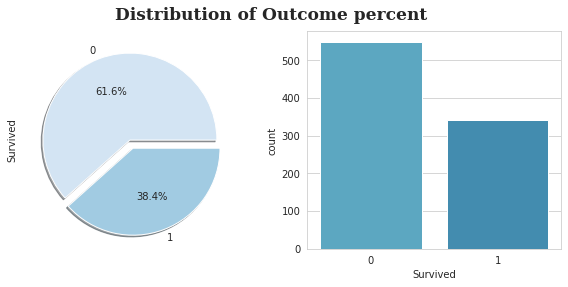

In [14]:
fig, axes = plt.subplots(1,2,figsize=(10,4))

titanic['Survived'].value_counts().plot.pie(
    explode=[0,0.1],autopct='%1.1f%%',ax=axes[0],shadow=True, colors=[Blues_palette[1],Blues_palette[3]]
)

sns.countplot('Survived',data=titanic,ax=axes[1], palette=[GnBu_palette[6],GnBu_palette[7]])
axes[1].patch.set_alpha(0)

fig.text(0.28,0.92,"Distribution of Outcome percent", fontweight="bold", fontfamily='serif', fontsize=17)

plt.show()

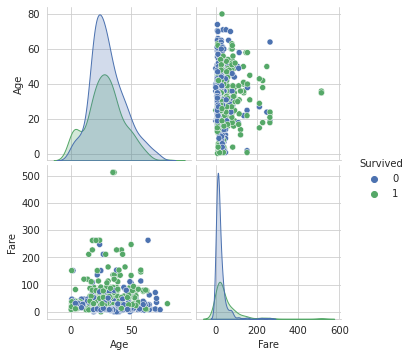

In [15]:
# Distribution of continue data over output column
continue_features = numerical_features.select_dtypes(include=['float64'])
sns.pairplot(titanic, hue = 'Survived', vars = continue_features )

- Most of the dead are close to 25 years of age
- The chance of survival increases if you pay passenger fares

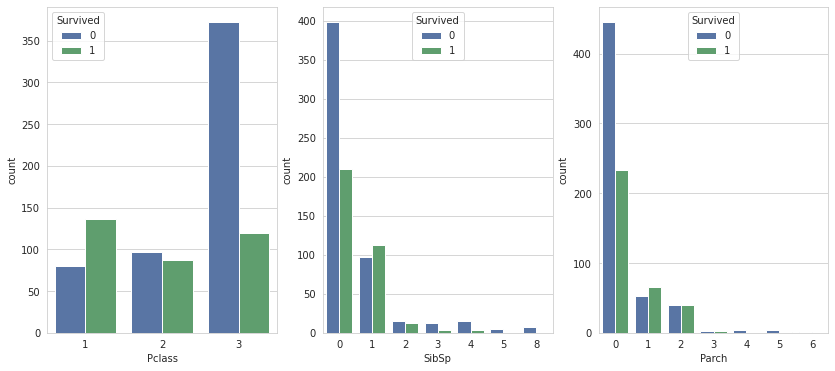

In [16]:
# Distribution of discrete data over output column
discrete_features = numerical_features.select_dtypes(include=['integer']).drop('PassengerId', axis=1)

fig, axes = plt.subplots(1,3, figsize=(14,6) )
#fig, ax =plt.subplots(1,2)
sns.countplot(x = 'Pclass', hue = 'Survived', data=titanic, ax=axes[0])
sns.countplot(x = 'SibSp', hue = 'Survived', data=titanic, ax=axes[1])
sns.countplot(x = 'Parch', hue = 'Survived', data=titanic, ax=axes[2])
fig.show()

- The chance of survival in first class is higher 
- The chance of survival is higher with one sibling on board
- The chance of survival is higher with 1-3 children on board

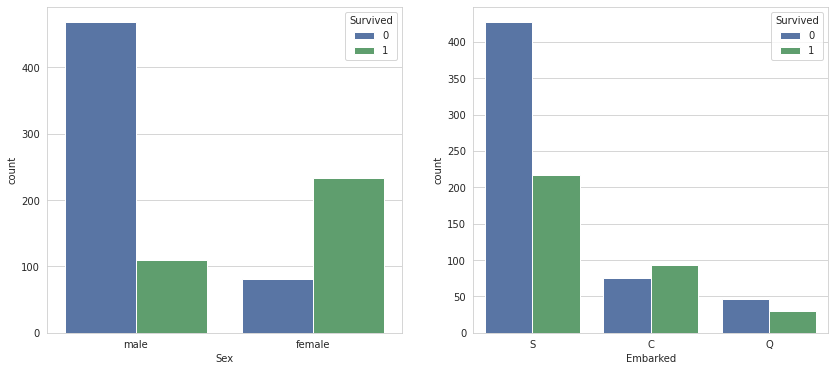

In [17]:
# Distribution of categorical data over output column

fig, axes = plt.subplots(1,2, figsize=(14,6) )
sns.countplot(x = 'Sex', hue = 'Survived', data=titanic, ax=axes[0])
sns.countplot(x = 'Embarked', hue = 'Survived', data=titanic, ax=axes[1])
fig.show()


- The chance of survival is higher for female
- The chance of survival is higher for passengers embarked in the port of Cherbourg

In [18]:
titanic[titanic.columns[:13]].corr().style.background_gradient(cmap='Blues')

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


# Step 3: Data Cleaning 

In [19]:
# drop the PassengerId, Cabin, Ticket and Name 
titanic.drop(['PassengerId', 'Cabin', 'Ticket', 'Name'], axis=1, inplace=True)

# drop the duplicate rows
titanic.drop_duplicates(inplace=True)
datasetShape(titanic)

The dataframe has 780 rows and 8 columns.


In [20]:
# remove all columns having no values
titanic.dropna(axis=1, how="all", inplace=True)
titanic.dropna(axis=0, how="all", inplace=True)
datasetShape(titanic)

The dataframe has 780 rows and 8 columns.


In [21]:
# remove columns having null values more than 30%
titanic.dropna(thresh=titanic.shape[0]*0.7,how='all',axis=1, inplace=True)
datasetShape(titanic)

The dataframe has 780 rows and 8 columns.


Missing Value Imputation

In [22]:
# missing values with percentage

def calc_missing(df):
    missing = df.isna().sum().sort_values(ascending=False)
    missing = missing[missing != 0]
    missing_perc = missing/df.shape[0]*100
    return missing, missing_perc
    

missing, missing_perc = calc_missing(titanic)
pd.concat([missing, missing_perc], axis=1, keys=['Total','Percent'])

,Total,Percent
Age,104,13.333333
Embarked,2,0.256410


Imputing Age with mean value as its on the average of the distribution and also relevant.

In [23]:
titanic.loc[titanic.Age.isna(), 'Age'] = titanic.Age.mean()
print("Missing values in Age:",titanic.Age.isna().sum())

Missing values in Age: 0


In [24]:
titanic_test.loc[titanic_test.Age.isna(), 'Age'] = titanic_test.Age.mean()
print("Missing values in Age:",titanic_test.Age.isna().sum())

Missing values in Age: 0


Imputing Embarked with mode value 

In [25]:
titanic.Embarked.mode()

0    S
dtype: object

In [26]:
titanic.loc[titanic.Embarked.isna(), 'Embarked'] = 'S'
print("Missing values in Embarked:",titanic.Embarked.isna().sum())

Missing values in Embarked: 0


In [27]:
titanic_test.loc[titanic_test.Embarked.isna(), 'Embarked'] = 'S'
print("Missing values in Embarked:",titanic_test.Embarked.isna().sum())

Missing values in Embarked: 0


# Step 4: Data Preparation

Outlier Treatment

Treating with the Survived target feature and other numerical features, which are skewed. We will take log of the feature values using np.log1p()

In [28]:
# extract all skewed features
temp_numerical_features, temp_categorical_features = divideFeatures(titanic)
# remove categorical features stored as int
temp_numerical_features.drop(['Pclass'], axis=1, inplace=True)
skewed_features = temp_numerical_features.apply(lambda x: x.skew()).sort_values(ascending=False)

In [29]:
# transform skewed features
for feat in skewed_features.index:
    if skewed_features.loc[feat] > 0.5:
        titanic[feat] = np.log1p(titanic[feat])
        titanic_test[feat] = np.log1p(titanic_test[feat])


In [30]:
# outlier treatment for categorical features
def getCategoricalSkewed(categories, threshold):
    tempSkewedFeatures = []
    for feat in categories:
        for featValuePerc in list(titanic[feat].value_counts()/titanic.shape[0]):
            if featValuePerc > threshold:
                tempSkewedFeatures.append(feat)
    return list(set(tempSkewedFeatures))

# display all categorical skewed features which have value_counts > 90%
categoricalSkewed = getCategoricalSkewed(temp_categorical_features.columns, .90)
for feat in categoricalSkewed:
    print(titanic[feat].value_counts()/len(titanic))
    print()

No skewed categorical features

In [ ]:
#print("Before Removing:")
#datasetShape(titanic)

# removing skewed categorical data 
#titanic.drop(categoricalSkewed, axis=1, inplace=True)
#print("After Removing:")
#datasetShape(titanic)

Binning Features

In [31]:
# Titanic Pclass in three bins
titanic['Pclass'].replace([1,2,3], ['First', 'Second', 'Third'], inplace=True)
titanic_test['Pclass'].replace([1,2,3], ['First', 'Second', 'Third'], inplace=True)

Create Dummy Features

In [32]:
# extract numerical and categorical for dummy and scaling later

categorical_features.drop(['Name','Ticket', 'Cabin'], axis=1, inplace=True)

numerical_features, categorical_features = divideFeatures(titanic)
for feat in categorical_features.columns:
    dummyVars = pd.get_dummies(titanic[feat], drop_first=True, prefix=feat+"_")
    titanic = pd.concat([titanic, dummyVars], axis=1)
    titanic.drop(feat, axis=1, inplace=True)

    dummyVars_test = pd.get_dummies(titanic_test[feat], drop_first=True, prefix=feat+"_")
    titanic_test = pd.concat([titanic_test, dummyVars_test], axis=1)
    titanic_test.drop(feat, axis=1, inplace=True)

datasetShape(titanic)

The dataframe has 780 rows and 10 columns.


# Step 5: Data Modelling

Split Train-Test Data

In [33]:
# shuffle samples
df_shuffle = titanic.sample(frac=1, random_state=seed).reset_index(drop=True)

In [34]:
df_y = df_shuffle.pop('Survived')
df_X = df_shuffle

# split into train dev and test
X_train, X_test, y_train, y_test = skms.train_test_split(df_X, df_y, train_size=0.7, random_state=seed)
print(f"Train set has {X_train.shape[0]} records out of {len(df_shuffle)} which is {round(X_train.shape[0]/len(df_shuffle)*100)}%")
print(f"Test set has {X_test.shape[0]} records out of {len(df_shuffle)} which is {round(X_test.shape[0]/len(df_shuffle)*100)}%")

Train set has 546 records out of 780 which is 70%
Test set has 234 records out of 780 which is 30%


Feature Scaling

In [35]:
scaler = skp.StandardScaler()

# apply scaling to all numerical variables (float64) except dummy variables as they are already between 0 and 1

X_train[continue_features.columns] = scaler.fit_transform(X_train[continue_features.columns])

# scale test data with transform()
X_test[continue_features.columns] = scaler.transform(X_test[continue_features.columns])

titanic_test[continue_features.columns] = scaler.transform(titanic_test[continue_features.columns])


# view sample data
X_train.describe()

,Age,SibSp,Parch,Fare,Pclass__Second,Pclass__Third,Sex__male,Embarked__Q,Embarked__S
count,5.460000e+02,546.000000,546.000000,5.460000e+02,546.000000,546.000000,546.000000,546.000000,546.000000
mean,-2.277381e-17,0.297132,0.253639,-2.196046e-16,0.217949,0.507326,0.620879,0.069597,0.730769
std,1.000917e+00,0.449687,0.433760,1.000917e+00,0.413231,0.500405,0.485613,0.254700,0.443967
min,-2.134420e+00,0.000000,0.000000,-3.197598e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-6.008509e-01,0.000000,0.000000,-8.991047e-01,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.956525e-02,0.000000,0.000000,-2.351378e-01,0.000000,1.000000,1.000000,0.000000,1.000000
75%,4.850895e-01,0.693147,0.693147,5.233803e-01,0.000000,1.000000,1.000000,0.000000,1.000000
max,3.724505e+00,2.197225,1.945910,3.314540e+00,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
smote = SMOTE()
X_over, y_over = smote.fit_resample(X_train,y_train)

In [37]:
X_over.shape

(626, 9)

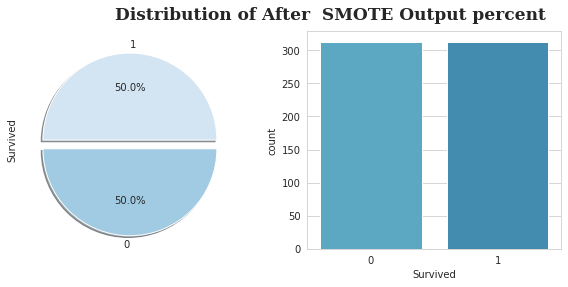

In [38]:
fig, axes = plt.subplots(1,2,figsize=(10,4))

y_over.value_counts().plot.pie(
    explode=[0,0.1],autopct='%1.1f%%',ax=axes[0],shadow=True, colors=[Blues_palette[1],Blues_palette[3]]
)

sns.countplot(y_over, ax=axes[1], palette=[GnBu_palette[6],GnBu_palette[7]])
axes[1].patch.set_alpha(0)

fig.text(0.28,0.92,"Distribution of After  SMOTE Output percent", fontweight="bold", fontfamily='serif', fontsize=17)

plt.show()

# Before SMOTE

In [39]:
# Evaluation function definition

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuacy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    print('confusion')
    print(confusion)
    print('accuacy : {}'.format(np.around(accuacy,4)))
    print('precision: {}'.format(np.around(precision,4)))
    print('recall : {}'.format(np.around(recall,4)))
    print('F1 : {}'.format(np.around(f1,4)))  
    print('ROC_AUC : {}'.format(np.around(roc_auc,4)))

Logistic Regression Model

In [40]:
lg_reg = LogisticRegression()

lg_reg.fit(X_train, y_train)
pred = lg_reg.predict(X_test)
pred_proba = lg_reg.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[121  24]
 [ 25  64]]
accuacy : 0.7906
precision: 0.7273
recall : 0.7191
F1 : 0.7232
ROC_AUC : 0.8571


Classiﬁcation Accuracy = (TP+TN) / (TP + TN + FP + FN)

Misclassiﬁcation rate (Error Rate) = (FP + FN) / (TP + TN + FP + FN)

Precision = TP/Total TRUE Predictions = TP/ (TP+FP) (When model predicted TRUE class, how often was it right?)

Recall = TP/ Actual TRUE = TP/ (TP+FN) (when the class was actually TRUE, how often did the classiﬁer get it right?)

F1-Score = 2/(1/Recall + 1/Precision) (is a harmonic mean of Precision and Recall, and so it gives a combined idea about these two metrics. It is maximum when Precision is equal to Recall.)

Random Forest Model

In [41]:
rf_clf = RandomForestClassifier()
param = {'n_estimators' : [100],
         'max_depth':[8,9,10],
         'min_samples_split':[2,5,7],
         'min_samples_leaf':[6.5,7,7.5]
        }

In [42]:
grid = GridSearchCV(rf_clf,param_grid = param,scoring = 'accuracy',cv=5)
grid.fit(X_train ,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 9, 10],
                         'min_samples_leaf': [6.5, 7, 7.5],
                         'min_samples_split': [2, 5, 7],
                         'n_estimators': [100]},
             scoring='accuracy')

In [43]:
grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 7,
 'min_samples_split': 5,
 'n_estimators': 100}

In [44]:
grid.best_score_

0.7874728940783987

In [45]:
pred = grid.predict(X_test)
pred_proba = grid.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[130  15]
 [ 32  57]]
accuacy : 0.7991
precision: 0.7917
recall : 0.6404
F1 : 0.7081
ROC_AUC : 0.8653


LightGBM Classification Modeling

In [47]:
model = lgb.LGBMClassifier(
    n_estimators=400,
    num_leaves=20,
    min_data_in_leaf=60,
    learning_rate=0.01,
    boosting='gbdt',
    objective='binary',
    metric='auc',
    Is_training_metric=True,
    n_jobs=-1
)

In [48]:
model.fit(X_train,y_train)

[LightGBM] [Warning] Unknown parameter: Is_training_metric
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


LGBMClassifier(Is_training_metric=True, boosting='gbdt', learning_rate=0.01,
               metric='auc', min_data_in_leaf=60, n_estimators=400,
               num_leaves=20, objective='binary')

In [49]:
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[127  18]
 [ 35  54]]
accuacy : 0.7735
precision: 0.75
recall : 0.6067
F1 : 0.6708
ROC_AUC : 0.8611


SGD Classification Model

In [59]:
from sklearn.linear_model import SGDClassifier

clf_SGD = SGDClassifier(loss="squared_loss", penalty="l2", max_iter=4500,tol=-1000, random_state=1)
clf_SGD.fit(X_train,y_train)
pred = clf_SGD.predict(X_test)
pred_proba = lg_reg.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[120  25]
 [ 24  65]]
accuacy : 0.7906
precision: 0.7222
recall : 0.7303
F1 : 0.7263
ROC_AUC : 0.8506


# After SMOTE

Logistic Regression Model

In [50]:
lg_reg = LogisticRegression()

lg_reg.fit(X_over, y_over)
pred = lg_reg.predict(X_test)
pred_proba = lg_reg.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[116  29]
 [ 19  70]]
accuacy : 0.7949
precision: 0.7071
recall : 0.7865
F1 : 0.7447
ROC_AUC : 0.8506


Random Forest Model

In [51]:
rf_clf = RandomForestClassifier()
param = {'n_estimators' : [200],
         'max_depth':[10],
         'min_samples_split':[2],
         'min_samples_leaf':[7]
        }

In [52]:
grid = GridSearchCV(rf_clf,param_grid = param,scoring = 'accuracy',cv=5)
grid.fit(X_over ,y_over)

pred = grid.predict(X_test)
pred_proba = grid.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[119  26]
 [ 26  63]]
accuacy : 0.7778
precision: 0.7079
recall : 0.7079
F1 : 0.7079
ROC_AUC : 0.8606


LightGBM Classification Model

In [53]:
model = lgb.LGBMClassifier(
    n_estimators=400,
    num_leaves=20,
    min_data_in_leaf=60,
    learning_rate=0.01,
    boosting='gbdt',
    objective='binary',
    metric='auc',
    Is_training_metric=True,
    n_jobs=-1
)

In [54]:
model.fit(X_over,y_over)

[LightGBM] [Warning] Unknown parameter: Is_training_metric
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] min_data_in_leaf is set=60, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=60


LGBMClassifier(Is_training_metric=True, boosting='gbdt', learning_rate=0.01,
               metric='auc', min_data_in_leaf=60, n_estimators=400,
               num_leaves=20, objective='binary')

In [55]:
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[124  21]
 [ 31  58]]
accuacy : 0.7778
precision: 0.7342
recall : 0.6517
F1 : 0.6905
ROC_AUC : 0.854


SGD Classification Model

In [60]:
from sklearn.linear_model import SGDClassifier

clf_SGD = SGDClassifier(loss="squared_loss", penalty="l2", max_iter=4500,tol=-1000, random_state=1)
clf_SGD.fit(X_over,y_over)
pred = clf_SGD.predict(X_test)
pred_proba = lg_reg.predict_proba(X_test)[:,1]
get_clf_eval(y_test, pred, pred_proba)

confusion
[[116  29]
 [ 16  73]]
accuacy : 0.8077
precision: 0.7157
recall : 0.8202
F1 : 0.7644
ROC_AUC : 0.8506


# Step 6: Submission

Re-run the best model (Logistic Regression after SMOTE) to update the 'pred' variable

In [61]:
# Create a list of columns to be used for the predictions
target_test_columns = X_train.columns
target_test_columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass__Second', 'Pclass__Third',
       'Sex__male', 'Embarked__Q', 'Embarked__S'],
      dtype='object')

In [62]:
X_train.columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass__Second', 'Pclass__Third',
       'Sex__male', 'Embarked__Q', 'Embarked__S'],
      dtype='object')

In [63]:
# Create a list of columns to be used for the predictions
target_test_columns = X_train.columns
target_test_columns

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Pclass__Second', 'Pclass__Third',
       'Sex__male', 'Embarked__Q', 'Embarked__S'],
      dtype='object')

In [64]:
titanic_test.columns

Index(['PassengerId', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare',
       'Cabin', 'Pclass__Second', 'Pclass__Third', 'Sex__male', 'Embarked__Q',
       'Embarked__S'],
      dtype='object')

In [65]:
titanic_test_for_pred = titanic_test[target_test_columns]

In [66]:
# check null values

pd.DataFrame(titanic_test_for_pred.isnull().sum(), columns=["Null Count"]).style.background_gradient(cmap='Blues')

,Null Count
Age,0
SibSp,0
Parch,0
Fare,1
Pclass__Second,0
Pclass__Third,0
Sex__male,0
Embarked__Q,0
Embarked__S,0


Imputing Fare with mean value

In [67]:
titanic_test_for_pred.loc[titanic_test_for_pred.Fare.isna(), 'Fare'] = titanic_test_for_pred.Fare.mean()
print("Missing values in Fare:",titanic_test_for_pred.Fare.isna().sum())

Missing values in Fare: 0


In [72]:
pred = clf_SGD.predict(titanic_test_for_pred)

pred[:20]

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1])

In [73]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = titanic_test['PassengerId']
submission['Survived'] = pred # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [74]:
# Checking for inconsistencies

if len(submission) == len(titanic_test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [77]:
submission.to_csv('/kaggle/working/submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=375c83c5-9c17-48bb-b813-ed40329e9d6c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>